In [ ]:
import numpy as np
from scipy.fftpack import fft2, ifft2
from numpy.fft import fftshift, ifftshift
from PIL import Image
import matplotlib.pyplot as plt


# imagen host de 1614x1614, imagen a esconder de 143x143
imagen_host = np.array(Image.open("prueba2.jpg").convert('L'))

img1 = imagen_host.copy()
img3 = np.array(Image.open("img260.png").convert("L"))


# Ejercicio 1
Usar LSB para ocultar un mensaje, luego, decodificarlo

1. Importar una imagen host
2. Aplanar la imagen como array. Cada 8 bits tengo un pixel
3. Elegir un mensaje
4. Pasar mensaje a binario
6. Cada 8 bits en mi imagen, reemplazo el último bit por el del mensaje
7. Sigo iterando hasta encontrar '&' en mi mensaje

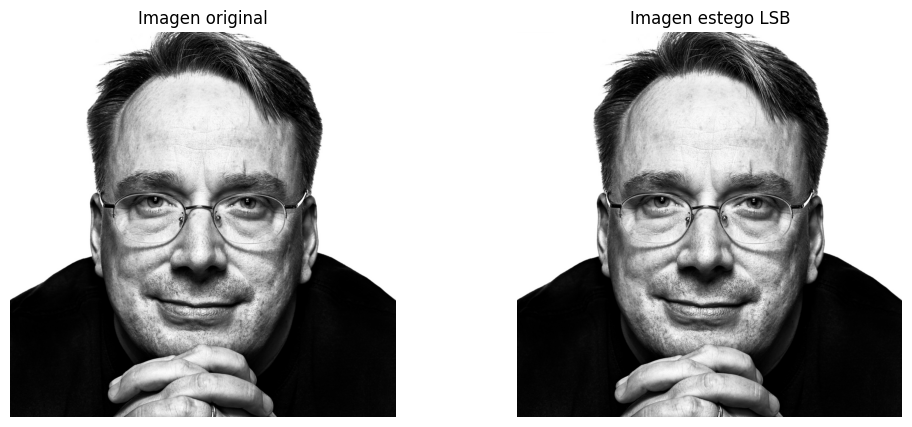

In [174]:
def texto_a_binario(msj):
    # mensaje -> ascii y ascii -> binario
    # fin de mensaje con &
    msj += '&'
    binario = ''
    
    # cada letra se pasa a ascii con ord() y luego a binario con format()
    for letra in msj:
        ascii = ord(letra)
        bin8 = format(ascii,'08b')
        # concateno resultado en array a retornar
        binario += bin8
        
    return binario

def LSB (host, msj):
    # flatten para recorrer la imagen como array (despues hacemos reshape)
    host = host.flatten()
    long_msj = len(msj)
    
    # si el mensaje entra en la imagen
    if (long_msj <= len(host)):
        for k in range(long_msj):
            val = host[k]
            
            # paso valor uint8 a bit
            val = bin(val)
            # val[:-1] me da todo el array excepto el último bit
            val_nuevo = val[:-1] + mensaje[k]
            host[k] = int(val_nuevo, 2)
            
    # si el mensaje es demasiado largo, informar
    else:
        print("El mensaje es demasiado largo")
        
    return host

msj = "YOU SHALL NOT PASS"
mensaje = texto_a_binario(msj)

# guardo el tamaño de la imagen para poder recuperarla después
x, y = img1.shape

img_LSB = LSB (img1,mensaje)
img_LSB = img_LSB.reshape((x,y))


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img1, cmap = "gray")
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_LSB, cmap = "gray")
plt.title("Imagen estego LSB")
plt.axis('off')
plt.show()

# guardar como archivo estego > img_LSB es un array
img_guardar = Image.fromarray(img_LSB)
img_guardar.save("estego_ej1.png")

### DECODIFICADOR > EJERCICIO 1
1. Volcar la imagen en una matriz (matriz de bytes)
2. Pasar de matriz a array (array de bytes)
3. Recorro el array 

In [175]:
# DECODIFICADOR
def decodificar_mensaje(imagen):
    # como la imagen recibida es png, la cargo como matriz de bytes y la paso a array de bytes
    img = np.array(Image.open(imagen).convert('L'))
    img = img.flatten()
    
    msj_decodificado = ""
    k = 0
    fin = False

    while (not fin and k+8<=len(img)):
    # k va contando los bits que se leen. si a la img le quedan menos de 8, no los puede leer
        bits = ""
        for i in range(8):
            bits += str(img[k] & 1)
            k += 1
            
        # paso bits a byte, luego byte a char
        letra = chr(int(bits, 2))
        
        if letra == '&':
            fin = True
        else:
            msj_decodificado += letra
            
    return msj_decodificado

msg_oculto = decodificar_mensaje("estego_ej1.png")
print(f"Mensaje oculto: {msg_oculto}")

Mensaje oculto: YOU SHALL NOT PASS


# Ejercicio 2
Usar la TFT2 para ocultar una imagen, luego, decodificarla
PROP: P(m,n)=P(−m,−n)

1. Importar una imagen a ocultar (matriz de bytes con tamaño m,n)
2. Aplanar la matriz (array de bytes con tamaño m*n)
3. Pasar de bytes a bits (array de bits con tamaño 8*(m*n))
5. Aplicarle la transformada 2D de Fourier a imagen host
6. Hay que separar parte real de parte imaginaria para cada elemento i
7. Cambiar el signo b. Si bit_oc=0 y b<0 o si bit_oc=1 y b>=0, -b
8. Cuando terminé de ocultar el mensaje, obtengo matriz de reales e imaginarios en 1C
9. Para lograr una imagen real, si cambie en el primer cuadrante cambio en el conjugado
10. Para visualizar la imagen, aplico inversa de la tft2

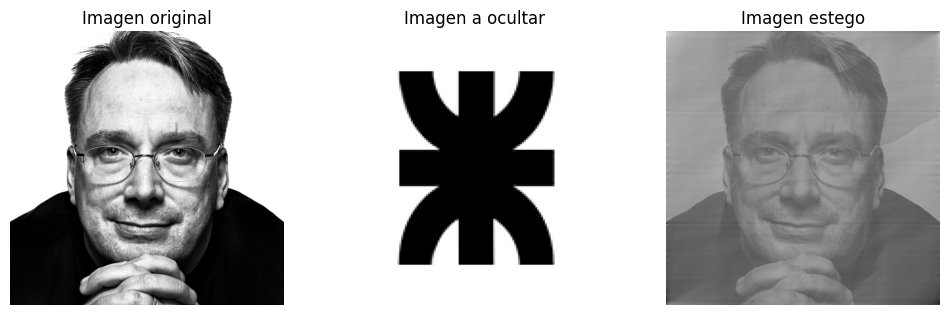

In [190]:
def bytes_a_bits (img):
    return np.unpackbits(img.astype(np.uint8)).astype(np.uint8)

def ocultar_img (host, secreto):
    # HOST: Matriz con comp fourier
    # SECRETO: Array de bits
    indx = 0
    m, n = host.shape
    
    for i in range(m//2):
        for k in range(n//2):
            if (indx == len(secreto)): break
            
            real = np.real(host[i,k])
            imag = np.imag(host[i,k])
            bit = secreto[indx]
             
            if ((bit==0 and imag<0) or (bit==1 and imag>=0)):
                imag=-imag
                    
            host[i,k] = real + 1j*imag
            indx+=1
        
    return host


def conjugado(fft_cuad1):
    m, n = fft_cuad1.shape
    cuad1_sim = fft_cuad1.copy()
    
    for i in range(m):
        for j in range(n):
            conj_i = (-i) % m
            conj_j = (-j) % n
            cuad1_sim[conj_i, conj_j] = np.conj(fft_cuad1[i, j])
            
    return cuad1_sim


def plotear (img1, img3, estego):
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(img1, cmap="gray")
    plt.title("Imagen original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img3, cmap="gray")
    plt.title("Imagen a ocultar")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(estego, cmap="gray")
    plt.title("Imagen estego")
    plt.axis('off')

    plt.show()


secreto = img3.flatten()
secreto = bytes_a_bits(secreto)

host_fft = fft2(img1)

# Recibo la matriz de transformadas con los bits ocultos, SOLO EN PRIMER CUADRANTE
estego_1c = ocultar_img(host_fft,secreto)

# Para poder tener una imagen real, tengo que usar simetría conjugada
estego_tft = conjugado(estego_1c)
    
estego_tft = estego_tft.reshape((x,y))
# COPIA ANTES DE APLICAR INVERSA
copia_es = estego_tft.copy()
estego = (ifft2(estego_tft)).real

# guardar la imagen para después decodificar
p = plt.imsave('estego_ej2.png', estego, cmap='gray')    
plotear (img1, img3, estego)


### DECODIFICADOR > EJERCICIO 2

1. Recorro mi matriz transformada solo en primer cuadrante
2. Si el signo de la parte imaginaria es -1, guardo un 1. Si no, un 0
3. Itero hasta la longitud de mi secreto
4. Obtengo un array de bits
5. Paso este a un array de bytes
6. Hago reshape para obtener una matriz de bytes con el tamaño original del secreto
 

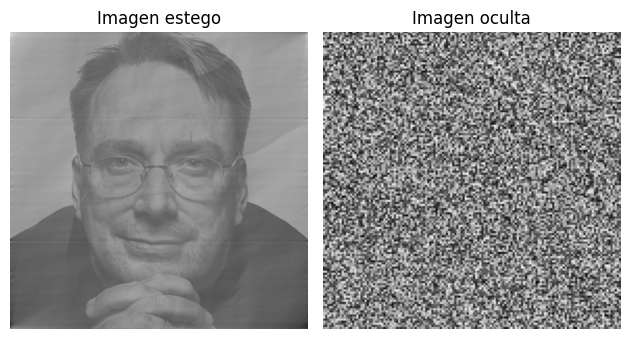

In [198]:
def decod_imagen (imagen, long_secreto):
    # imagen es una matriz con componentes fourier modificados
    img_decod = []
    m, n = imagen.shape
    indx = 0
    
    for i in range(m//2):
        for k in range(n//2):
            
            if (indx==long_secreto): break
            
            imag = np.imag(imagen[i,k])

            if (imag>=0):
                img_decod.append(0)
            else:
                img_decod.append(1)
                
            indx+=1
            
    # img_decod es list, así que paso a ndarray
    # si recupere bien los bits, debería tener 163592 bits        
    
    img_decodif = np.packbits(img_decod)
    return img_decodif


oculto = img3.copy()
oculto = oculto.flatten()
# PARA IMAGEN DE 143X143 -> CANT DE BYTES=20449
ocultob = np.unpackbits(oculto)
cant_bytes = len(ocultob)


# Le paso una matriz con las componentes de Fourier
# Recibo array de 20449 bytes
este_2 = decod_imagen(copia_es, cant_bytes)
im_oculta = este_2.reshape((143,143))


plt.subplot(1,2,1)
plt.imshow(estego, cmap="gray")
plt.title("Imagen estego")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(im_oculta, cmap="gray")
plt.title("Imagen oculta")
plt.axis('off')

plt.tight_layout()
plt.show()


# Ejercicio 3

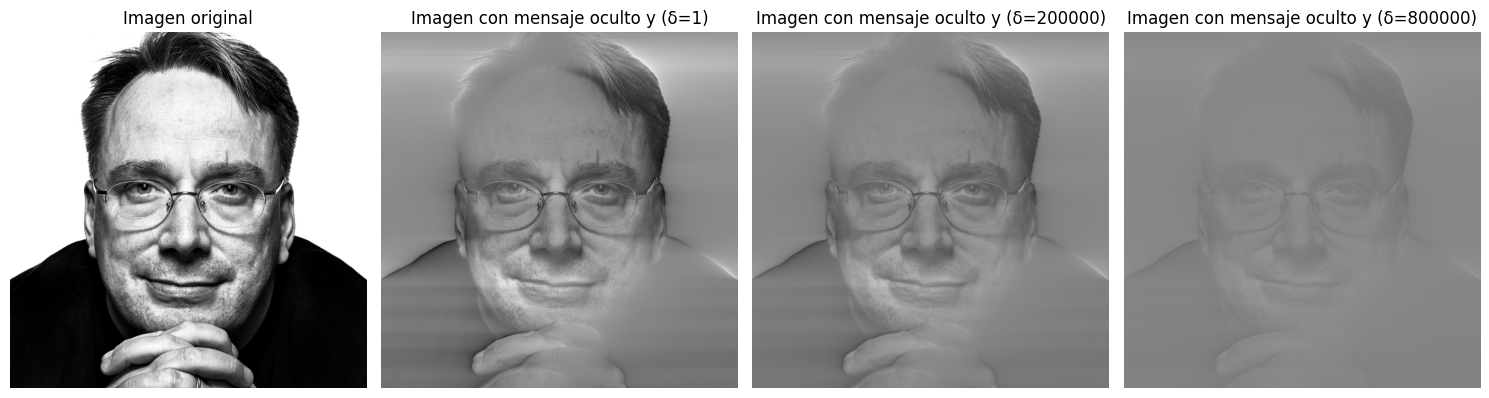

In [219]:
def img_a_bin(img):
    return np.unpackbits(img.astype(np.uint8)).astype(np.uint8)

def modificar_coeficientes(fft_img, mensaje, delta):
    fft_mod = fft_img.copy()
    fila, cols = fft_mod.shape
    index = 0
    total_bits = len(mensaje)
    
    for i in range(fila):
        for j in range(cols):
            if index >= total_bits:
                break
            
            # trabajo solo en el primer cuadrante y después hago el conjugado
            if (i < fila//2 and j < cols//2):
                # aislo parte real
                a = fft_mod[i, j].real
                
                # guardo el signo de a en signo_a
                if (a >= 0): signo_a = 1 
                else: signo_a= -1
                    
                # fórmula para q=abs(round(a/δ))
                q_a = np.abs(np.round(a / delta))
                
                if (index < total_bits):
                    bit = mensaje[index]
                    # si tengo que ocultar 1 y q par, q++
                    # si tengo que ocultar 0 y q impar, q++
                    if (bit == 1 and q_a % 2 == 0) or (bit == 0 and q_a % 2 == 1):
                        q_a += 1
                        
                    # a'=signo.q_a.delta    
                    a_nuevo = signo_a * q_a * delta
                    # como ya oculté un bit de mensaje, itero
                    index += 1
                else:
                    # si ya terminé de ocultar el mensaje, no modifico el dato orig.
                    a_nuevo = a
                
                
# tengo que volver a verificar el index, porque puede que al terminar de asignar el mensaje en la parte real me salga de rango
                
                if (index < total_bits):
                    # aislo la parte imaginaria
                    b = fft_mod[i, j].imag
                    
                    # guardo el signo de b en signo_b
                    if (b >= 0): signo_b = 1 
                    else: signo_b= -1
                        
                    # fórmula para q=abs(round(b/δ))
                    q_b = np.abs(np.round(b / delta))
                    
                    bit = mensaje[index]
                    
                    # si tengo que ocultar 1 y q par, q++
                    # si tengo que ocultar 0 y q impar, q++
                    if (bit == 1 and q_b % 2 == 0) or (bit == 0 and q_b % 2 == 1):
                        q_b += 1
                        
                    # b'=signo.q_b.delta  
                    b_nuevo = signo_b * q_b * delta
                    index += 1
                else:
                    b_nuevo = fft_mod[i, j].imag
                
                # si terminé de modificar, guardo el bit como a'+b'j
                fft_mod[i, j] = a_nuevo + 1j * b_nuevo
    
    # Mantener simetría conjugada
    for i in range(fila):
        for j in range(cols):
            if ((i >= fila//2) or (j >= cols//2)):
                if i != 0:
                    conj_i = fila - i - 1
                else: conj_i = 0
                if j != 0:
                    conj_j = cols - j - 1
                else: conj_j = 0
                
                # np.conjugate me devuelve el conjugado i-j de i+j
                fft_mod[i, j] = np.conjugate(fft_mod[conj_i, conj_j])
    
    return fft_mod

# <<< FIN DE FUNCIONES >>>

# convierto imagen a array con binarios
bits_msg = img_a_bin(img3)

# Padding si es necesario
padding = (8 - len(bits_msg) % 8) % 8
bits_msg_padded = np.concatenate([bits_msg, np.zeros(padding, dtype=np.uint8)])


# tft2 de la imagen portadora y aplicar shift, de lo contrario obtengo cruz oscura en medio
# shift agarra las frecuencias más cercanas a 0 y las deja cerca del centro
fft_img = fftshift(fft2(img1.astype(float)))

# delta muy alto vs delta cercano a 0
delta1 = 800000
delta2 = 200000
delta3 = 1

# CASO 1: DELTA MEDIANO
fft_mod1 = modificar_coeficientes(fft_img, bits_msg, delta1)
# aplico inversa de fft e inversa de fft shift
img_mod1 = (ifft2(ifftshift(fft_mod1))).real

# CASO 2: DELTA GRANDE
fft_mod2 = modificar_coeficientes(fft_img, bits_msg, delta2)
img_mod2 = (ifft2(ifftshift(fft_mod2))).real

# CASO 3: DELTA=1
fft_mod3 = modificar_coeficientes(fft_img, bits_msg, delta3)
img_mod3 = (ifft2(ifftshift(fft_mod3))).real

# PLOTEO
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(img1, cmap='gray')
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_mod3, cmap='gray')
plt.title(f"Imagen con mensaje oculto y (δ={delta3})")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_mod2, cmap='gray')
plt.title(f"Imagen con mensaje oculto y (δ={delta2})")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_mod1, cmap='gray')
plt.title(f"Imagen con mensaje oculto y (δ={delta1})")
plt.axis('off')

plt.tight_layout()
plt.show()

# NOTA: A MEDIDA QUE SE AUMENTA DELTA SE VA PERDIENDO INFORMACIÓN, SE ELIMINAN FRECUENCIAS ALTAS
# SI DELTA ES CERCANO A 0, LOS COEFICIENTES NO CAMBIAN MUCHO Y SE PARECE DEMASIADO A IMAGEN ORIGINAL
